# Домашнее задание 1. Autoencoders & Fréchet Inception Distance

В этом задании вы:
1. Напишете свой автоэнкодер (AE) для датасета CIFAR10.
2. Используете эмбеддинги энкодера, чтобы посчитать Fréchet Inception Distance (FID) между классами CIFAR10.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms

from sklearn.ensemble import GradientBoostingClassifier

from tqdm.auto import tqdm, trange

from collections import defaultdict
import random

In [2]:
def set_seed(seed: int):
    """
    Sets the seed for reproducibility across numpy, random, torch.

    Parameters:
    seed (int): The seed value to be set.
    """
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # Torch for CPU and device-agnostic
    torch.cuda.manual_seed(seed)  # GPU: CUDA 
    torch.cuda.manual_seed_all(seed)  # Multi-GPU
    torch.backends.cudnn.deterministic = True  # Deterministic behavior for CUDA
    torch.backends.cudnn.benchmark = False  # Disable cuDNN benchmarking

SEED = 42
set_seed(SEED)

In [3]:
device: str = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
device

'mps'

Для работы с данными будем использовать `torchvision`.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

In [5]:
train_dataset = datasets.CIFAR10(
    '../data/cifar',
    train=True,
    transform=transform,
    download=True)
val_dataset = datasets.CIFAR10(
    '../data/cifar',
    train=False,
    transform=transform,
    download=True)
len(train_dataset), len(val_dataset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

Нам нужно будет уметь «разнормализовать» картинки (обратно в $[0,1]$) для визуализации.

In [6]:
def denormalize_image(image):
    return (image + 1) / 2

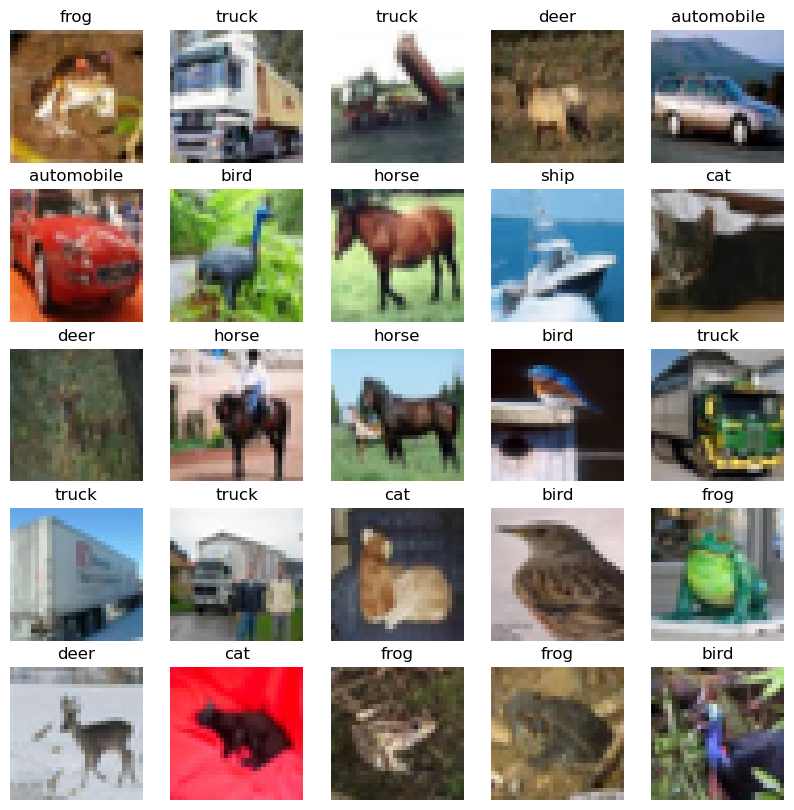

In [7]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

Размерность картинки в CIFAR10: 3 канала, 32×32 пикселя.

In [8]:
image.shape

torch.Size([3, 32, 32])

In [9]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
len(train_loader), len(val_loader)

(391, 10000)

## Задание 1. Обучить AE (3 балла)

Постройте свой AE: напишите классы `Encoder` и `Decoder`. Можно использовать любые слои, которые посчитаете нужными: `nn.Conv2d`, `nn.AvgPool2d`, `nn.MaxPool2d`, а также в декодере — `nn.Upsample`, `nn.ConvTranspose2d` и т.д.  

![](https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        ### END SOLUTION

    def forward(self, x):
        ### BEGIN SOLUTION
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        return x
        ### END SOLUTION

In [11]:
encoder = Encoder()
noise = torch.rand(1, 3, 32, 32) - 1
assert encoder(noise).view(-1).shape[0] < 1*3*32*32, "Размер эмбеддинга должен быть меньше исходного!"

In [12]:
print(encoder(noise).shape)

torch.Size([1, 32, 2, 2])


In [13]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        self.upsample1 = nn.Upsample(scale_factor=4)
        self.conv1 = nn.ConvTranspose2d(32, 32, 3, 1, 1)
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.conv2 = nn.ConvTranspose2d(32, 32, 3, 1, 1)
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.conv3 = nn.ConvTranspose2d(32, 3, 3, 1, 1)
        ### END SOLUTION

    def forward(self, z):
        ### BEGIN SOLUTION
        x = self.upsample1(z)
        x = self.conv1(x)
        x = self.upsample2(x)
        x = self.conv2(x)
        x = self.upsample3(x)
        x = self.conv3(x)
        x = torch.sigmoid(x)
        return x
        ### END SOLUTION

In [14]:
decoder = Decoder()
noise = torch.rand(1, 3, 32, 32)
emb = encoder(noise)
assert decoder(emb).shape == (1, 3, 32, 32), "Декодер должен восстанавливать тензор формы (batch_size, 3, 32, 32)"

In [15]:
print(decoder(encoder(noise)).shape)

torch.Size([1, 3, 32, 32])


Для оценки качества энкодера возьмём его выходы как фичи для классификации (Gradient Boosting). Затем сравним скор классификации для необученного энкодера со скором обученного. Для ускорения расчета, мы используем только часть трейна.

In [16]:
def classification_score(encoder, _train_dataset, val_dataset, device, train_size=5000):
    encoder.eval()
    
    # Возьмём train_size случайных примеров для обучения GBDT
    train_dataset = Subset(_train_dataset, torch.randperm(len(_train_dataset))[:train_size])
    
    X_train = []
    y_train = []
    for image, label in tqdm(train_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_train.append(emb.cpu().numpy().reshape(-1))
        y_train.append(label)
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    
    clf = GradientBoostingClassifier(n_estimators=50, max_depth=5, verbose=1, random_state=SEED)
    clf.fit(X_train, y_train)
    
    X_val = []
    y_val = []
    for image, label in tqdm(val_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_val.append(emb.cpu().numpy().reshape(-1))
        y_val.append(label)
    X_val = np.stack(X_val)
    y_val = np.stack(y_val)
    
    return clf.score(X_val, y_val)

In [489]:
pretrain_score = classification_score(Encoder().to(device), train_dataset, val_dataset, device)
pretrain_score

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.1192            1.95m
         2           1.9874            1.92m
         3           1.8763            1.88m
         4           1.7809            1.83m
         5           1.6998            1.79m
         6           1.6243            1.75m
         7           1.5562            1.70m
         8           1.4928            1.66m
         9           1.4394            1.62m
        10           1.3872            1.58m
        20           1.0255            1.18m
        30           0.8118           47.11s
        40           0.6607           23.57s
        50           0.5434            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.3789

Напишите функцию `train`, которая обучает энкодер и декодер на **всём трейне**, возвращая средний MSE.

In [17]:
def train(loader, optim, encoder, decoder, device):
    encoder.train()
    decoder.train()
    criterion = nn.MSELoss()
    losses = []
    for image, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        image = image.to(device)
        
        optim.zero_grad()
        outputs = decoder(encoder(image))
        loss = criterion(outputs, image)
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
        ### END SOLUTION
    return sum(losses) / len(losses)

In [491]:
encoder.to(device)
decoder.to(device)

params = list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.AdamW(params)

loss = train(train_loader, optim, encoder, decoder, device)
assert type(loss) == float, "Функция train должна возвращать float"
assert 0 < loss < 1
loss

  0%|          | 0/391 [00:00<?, ?it/s]

0.2066653793501427

Напишите функцию `eval`, которая возвращает среднее MSE на всём валидационном датасете.  
Hint: Не забудьте выключить расчёт градиентов.

In [18]:
def eval(loader, encoder, decoder, device):
    encoder.eval()
    decoder.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for image, _ in tqdm(loader, leave=False):
            ### BEGIN SOLUTION
            image = image.to(device)
        
            outputs = decoder(encoder(image))
            loss = criterion(outputs, image)
        
            losses.append(loss.item())
            ### END SOLUTION
    return sum(losses) / len(losses)

In [493]:
loss = eval(val_loader, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/10000 [00:00<?, ?it/s]

0.18858491216609255

Ниже — функция `full_train`, которая возвращает обученныe энкодер и декодер. Обучите модель, а затем добавьте загрузку предобученных весов в начало функции.

In [494]:
ed = encoder.state_dict()
dd = decoder.state_dict()

In [19]:
def full_train(device, train_loader, val_loader):
    ### BEGIN SOLUTION
    encoder = Encoder() 
    decoder = Decoder()
        
    encoder.load_state_dict(ed) 
    decoder.load_state_dict(dd) 
        
    encoder.to(device)
    decoder.to(device)
    ### END SOLUTION
    
    # encoder = Encoder().to(device)
    # decoder = Decoder().to(device)
    
    params = list(encoder.parameters()) + list(decoder.parameters())
    optim = torch.optim.AdamW(params)
    train_loss = []
    val_loss = []
    n_epochs = 30
    for e in trange(n_epochs):
        e_train_loss = train(train_loader, optim, encoder, decoder, device)
        train_loss.append(e_train_loss)
        e_val_loss = eval(val_loader, encoder, decoder, device)
        val_loss.append(e_val_loss)
        print(f'Epoch: {e+1}/{n_epochs}')
        print(f'Train MSE loss: {e_train_loss:.4f}')
        print(f'Validation MSE loss: {e_val_loss:.4f}')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend()
    plt.title('MSE Loss')
    plt.grid()
    plt.show()
    return encoder, decoder

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1/30
Train MSE loss: 0.1882
Validation MSE loss: 0.1839


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 2/30
Train MSE loss: 0.1851
Validation MSE loss: 0.1822


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 3/30
Train MSE loss: 0.1838
Validation MSE loss: 0.1807


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 4/30
Train MSE loss: 0.1830
Validation MSE loss: 0.1803


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 5/30
Train MSE loss: 0.1825
Validation MSE loss: 0.1801


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 6/30
Train MSE loss: 0.1820
Validation MSE loss: 0.1792


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 7/30
Train MSE loss: 0.1817
Validation MSE loss: 0.1790


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 8/30
Train MSE loss: 0.1814
Validation MSE loss: 0.1788


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 9/30
Train MSE loss: 0.1812
Validation MSE loss: 0.1789


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 10/30
Train MSE loss: 0.1809
Validation MSE loss: 0.1786


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 11/30
Train MSE loss: 0.1808
Validation MSE loss: 0.1784


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 12/30
Train MSE loss: 0.1806
Validation MSE loss: 0.1783


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 13/30
Train MSE loss: 0.1805
Validation MSE loss: 0.1780


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 14/30
Train MSE loss: 0.1804
Validation MSE loss: 0.1780


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 15/30
Train MSE loss: 0.1803
Validation MSE loss: 0.1781


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 16/30
Train MSE loss: 0.1802
Validation MSE loss: 0.1778


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 17/30
Train MSE loss: 0.1801
Validation MSE loss: 0.1777


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 18/30
Train MSE loss: 0.1800
Validation MSE loss: 0.1778


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 19/30
Train MSE loss: 0.1799
Validation MSE loss: 0.1777


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 20/30
Train MSE loss: 0.1799
Validation MSE loss: 0.1777


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 21/30
Train MSE loss: 0.1798
Validation MSE loss: 0.1775


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 22/30
Train MSE loss: 0.1797
Validation MSE loss: 0.1774


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 23/30
Train MSE loss: 0.1797
Validation MSE loss: 0.1774


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 24/30
Train MSE loss: 0.1796
Validation MSE loss: 0.1774


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 25/30
Train MSE loss: 0.1796
Validation MSE loss: 0.1774


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 26/30
Train MSE loss: 0.1796
Validation MSE loss: 0.1772


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 27/30
Train MSE loss: 0.1794
Validation MSE loss: 0.1774


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 28/30
Train MSE loss: 0.1794
Validation MSE loss: 0.1772


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 29/30
Train MSE loss: 0.1794
Validation MSE loss: 0.1772


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 30/30
Train MSE loss: 0.1793
Validation MSE loss: 0.1773


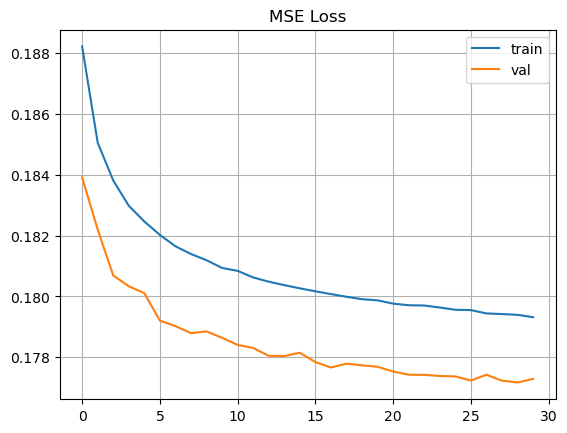

In [496]:
encoder, decoder = full_train(device, train_loader, val_loader)

In [497]:
score = classification_score(encoder, train_dataset, val_dataset, device, train_size=5000)
assert score > pretrain_score * 1.05, "Слишком низкий скор. Убедитесь, что ваш AE обучается."
score

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.0957            1.94m
         2           1.9547            1.91m
         3           1.8347            1.87m
         4           1.7341            1.83m
         5           1.6482            1.81m
         6           1.5705            1.77m
         7           1.5000            1.73m
         8           1.4401            1.69m
         9           1.3811            1.65m
        10           1.3276            1.61m
        20           0.9655            1.21m
        30           0.7528           48.62s
        40           0.6038           24.34s
        50           0.4944            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.407

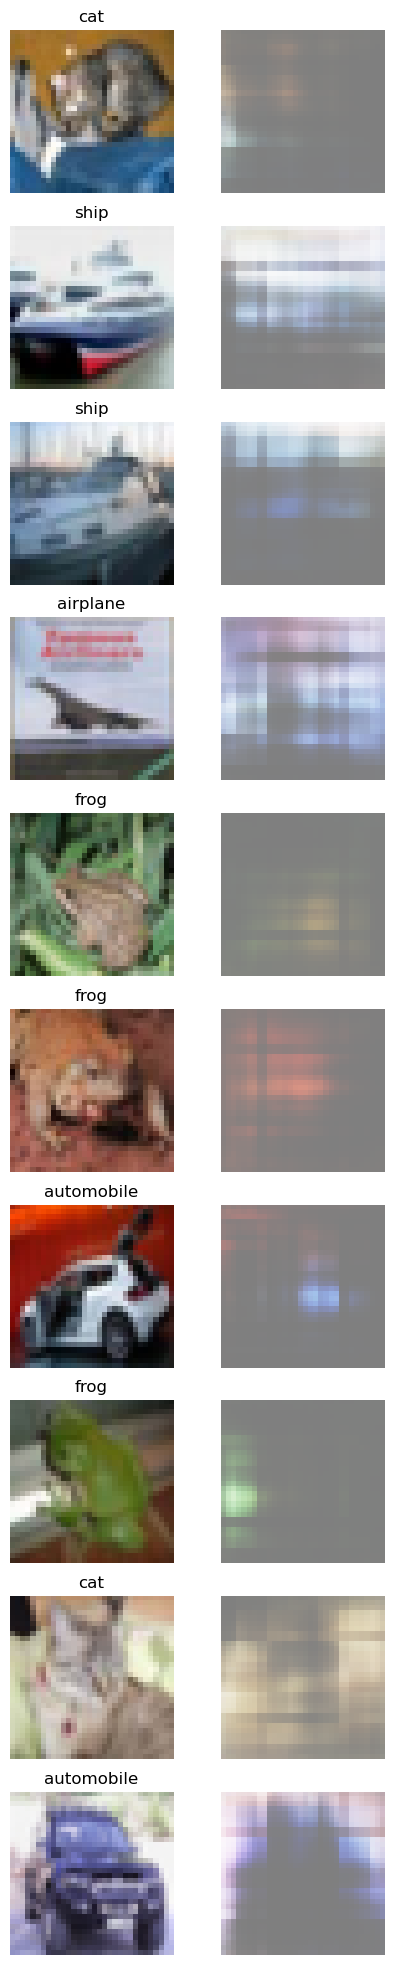

In [506]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
for index, (image, label) in enumerate(val_loader):
    plt.subplot(10, 2, index*2 + 1)
    plt.imshow(denormalize_image(image)[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title(text_labels[label])
    
    plt.subplot(10, 2, index*2 + 2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image)
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis('off')
    
    if index == 9:
        break

## Задание 2. FID дистанция между классами CIFAR10 (3 балла)

Теперь, используя bottleneck-представления обученного энкодера, посчитаем **Fréchet Inception Distance (FID)** между разными классами CIFAR10 на **валидационной** выборке.

Напомним формулу FID:
$$
\mathrm{FID} = \|\mu_r - \mu_g\|^2 + \operatorname{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2}).
$$

Реализуйте функцию `get_representations`, которая для заданного `DataLoader` и энкодера вернёт `defaultdict`, где:
- ключ: номер класса
- значение: список тензоров, соответствующих эмбеддингам картинок этого класса.

In [20]:
def get_representations(dataloader, encoder, device):
    representations = defaultdict(list)
    ### BEGIN SOLUTION
    with torch.no_grad():
        for _, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            embeddings = encoder(images)
            
            for i in range(len(labels)):
                class_label = int(labels[i].item())
                representations[class_label].append(embeddings[i])
    
    return representations
    ### END SOLUTION

In [508]:
representations = get_representations(val_loader, encoder, device)
assert len(representations) == 10, "Должно быть 10 ключей по количеству классов."
assert len(representations[0]) == 1000, "Количество эмбеддингов на класс не совпадает с ожидаемым."
assert type(representations[0][0]) == torch.Tensor

In [21]:
from scipy.linalg import sqrtm

def calculate_fid(repr1, repr2, eps=1e-6):
    ### BEGIN SOLUTION
    repr1 = np.reshape(repr1, (repr1.shape[0], -1))
    repr2 = np.reshape(repr2, (repr2.shape[0], -1))
    mu1 = np.mean(repr1, axis=0)
    mu2 = np.mean(repr2, axis=0)
    
    sigma1 = np.cov(repr1, rowvar=False)
    sigma2 = np.cov(repr2, rowvar=False)
    
    mu = mu1 - mu2
    
    sigma = sqrtm(np.dot(sigma1, sigma2))
    if not np.isfinite(sigma).all():
        offset = np.eye(sigma1.shape[0]) * eps
        sigma = sqrtm((sigma1 + offset).dot(sigma2 + offset))
        
    fid = np.sum(np.dot(mu, mu)) + np.trace(sigma1 + sigma2 - 2 * sigma)
    
    return fid
    ### END SOLUTION

In [510]:
# Посчитаем FID для каждой пары классов и сохраним в heatmap (10×10)
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid

# Проверки на корректность вычислений:
assert heatmap.shape == (10, 10), "Массив должен быть 10×10."
assert np.all(heatmap + 1e-5 > 0), "FID не может быть отрицательной."
airplane_ship = heatmap[0, 8]  # fid(airplane, ship)
airplane_frog = heatmap[0, 6]  # fid(airplane, frog)
truck_automobile = heatmap[9, 1]  # fid(truck, automobile)
truck_dog = heatmap[9, 5]  # fid(truck, dog)
assert airplane_ship < airplane_frog, "Ожидаем, что класс airplane ближе к ship, чем к frog"
assert truck_automobile < truck_dog, "Ожидаем, что класс truck ближе к automobile, чем к dog"

  0%|          | 0/10 [00:00<?, ?it/s]

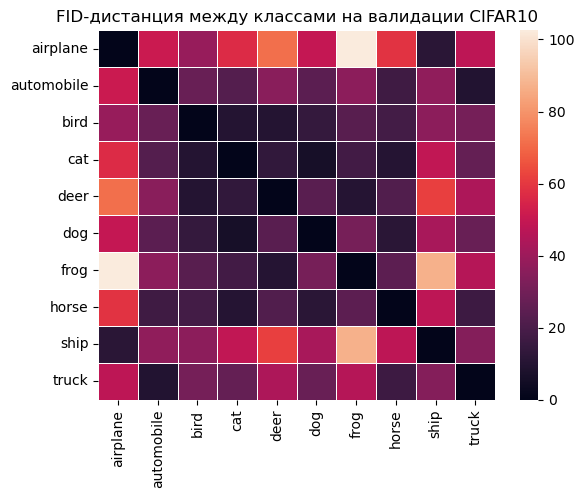

In [511]:
sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=text_labels, 
    yticklabels=text_labels
)
plt.title('FID-дистанция между классами на валидации CIFAR10')
plt.show()

## Задание 3 (3 балла)

Возьмите **любой** датасет из интернета, в котором есть **два разных класса** (например, «кошки и собаки», или какие-то другие). Посчитайте между ними FID, используя **тот же энкодер** (обученный на CIFAR10).

In [513]:
torch.save(encoder, 'encoder.pt')
torch.save(decoder, 'decoder.pt')

In [22]:
encoder = torch.load('encoder.pt')
decoder = torch.load('decoder.pt')

/var/folders/yl/bg_6c7_56kl413fpblgzt_5w0000gn/T/ipykernel_62748/4003920625.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load('encoder.pt')
/var/folde

In [79]:
train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
len(train_dataset), len(val_dataset)

100%|██████████| 182M/182M [00:18<00:00, 9.91MB/s] 


100%|██████████| 64.3M/64.3M [00:09<00:00, 6.57MB/s]


(73257, 26032)

In [80]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

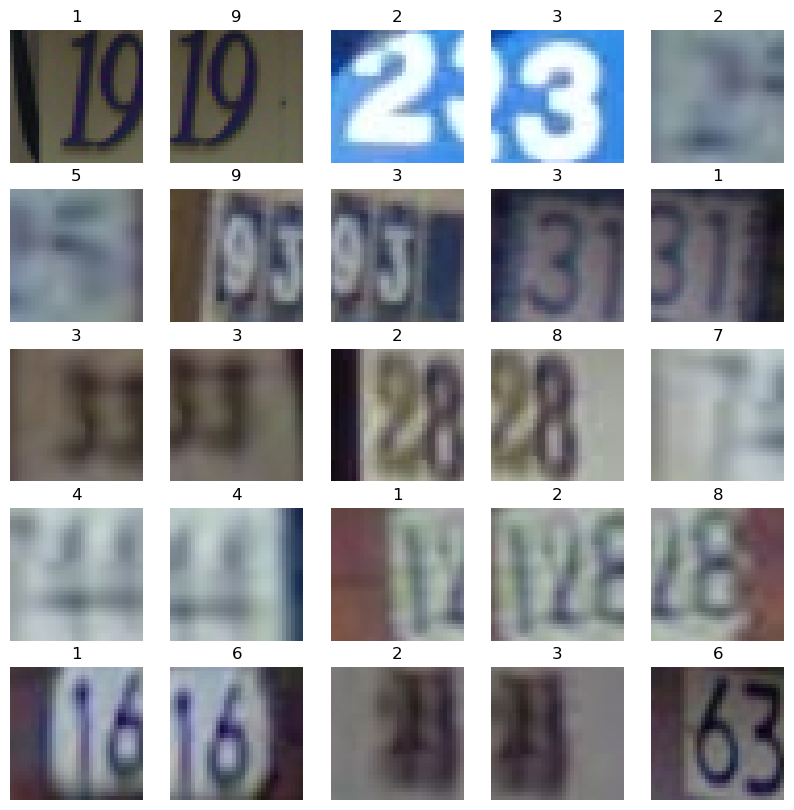

In [90]:
text_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

In [91]:
image.shape

torch.Size([3, 32, 32])

In [92]:
representations = get_representations(val_loader, encoder, device)

In [93]:
# Посчитаем FID для каждой пары классов и сохраним в heatmap (10×10)
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid

  0%|          | 0/10 [00:00<?, ?it/s]

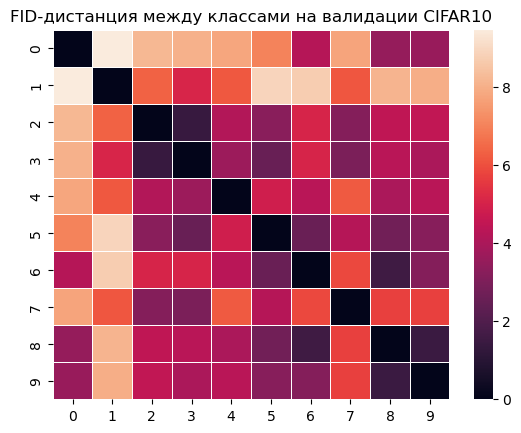

In [99]:
sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=text_labels, 
    yticklabels=text_labels
)
plt.title('FID-дистанция между классами на валидации CIFAR10')
plt.show()

## Задание 4 (1 балл)

Поздравляем, вы проделали большую работу! В этом разделе:
1. Опишите идеи, которые вы хотели бы попробовать, если бы у вас было больше времени или статьи, в которых решают подобные задачи.  
2. Приложите какой-нибудь свежий (последних пары лет) мем про генеративные модели. Если мем будет не смешным, увы, придётся снять баллы.

**Ответ:**
1. Я бы энкодер и декодер получше бы придумал, чтобы в итоге картинки нормально выглядили. 
2. <img src="https://datasciencedojo.com/wp-content/uploads/AI-meme-4.jpg.webp" width="700" height="500">